# Lab 4 (Due @ by 11:59 pm via Canvas/Gradescope)

Your Name: Diego Cicotoste

Due: Wednesday or Thursday, Nov. 20/21 @ 11:59 pm

### Submission Instructions
Submit this `ipynb` file to Gradescope (this can also be done via the assignment on Canvas).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the `ipynb` file to gradescope. **In addition:**
- Make sure your name is entered above
- Make sure you comment your code effectively
- If problems are difficult for the TAs/Profs to grade, you will lose points

### Tips for success
- Collaborate: bounce ideas off of each other, if you are having trouble you can ask your classmates or Dr. Gerber for help with specific issues, however...
- Under no circumstances may one student view or share their ungraded homework or quiz with another student [(see also)](http://www.northeastern.edu/osccr/academic-integrity), i.e. you are welcome to **talk about** (*not* show each other your answers to) the problems.

In [1]:
# you might use the below modules on this lab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

## Part 1: Read in, Plot and Interpret Data (20 points)

Can you use other numeric features of a song to predict which mode (Major or Minor) the song is in? To simplify the problem, and visualize it, we will narrow our set of $x$ features to consist of ($x_1$: energy, $x_2$: key, and $x_3$: loudness). On the Getting to Know You survey from the first week of class, many of you put your favorite song. These have been collected in a Spotify playlist ([link here](https://open.spotify.com/playlist/3lDbfa8bVjjcpJtFIoHBv2?si=bc1a57aa591742cd&nd=1&dlsi=b555927ecc744549)). Spotify also allows you to download detailed information about songs in playlists. Dr. Gerber has done this for you, **scaled the data**, and stored them in his github. Run the first code cell below to read it into this jupyter notebook.

After reading in the data, use the `.scatter_3d()` function from `plotly.express` to plot:

- `x = 'energy'`
- `y = 'key'`
- `z = 'loudness'`
- `color = 'mode'`

This is a function I haven't shown you, so please take a look at the [documentation](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d).

Based on the plot, can you say if there is a 2D plane that will perfectly separate the Major (1) from the Minor (-1) mode songs? Do you think it would still be helpful to create a perceptron decision boundary to help predict if a song is in major or minor mode with these data?

**Note** that I've already scaled the data for you and added a bias term in the first column (aren't I nice!).

In [2]:
# this code grabs the data set from Dr. Gerber's github and prints out the first 5 songs in the data set
# subsets to only include features of interest and re-sets Mode to be 1 or -1 (was 1 or 0)
url = './github.csv'
df_spot_raw = pd.read_csv(url)
df_spot = df_spot_raw[["energy", "key", "loudness", "mode", "song_title", "artist_name"]]
pd.Series(df_spot['mode']).replace(0, -1, inplace=True)
df_spot.insert(loc=0, column='bias', value=1)
scale_columns = ["energy", "key", "loudness"]
for feat in scale_columns:
    df_spot[feat] = (df_spot[feat] - df_spot[feat].mean()) / df_spot[feat].std()

df_spot.head()

,bias,energy,key,loudness,mode,song_title,artist_name
0,1,-0.326724,0.452859,0.669783,-1,DEEP IN THE WATER,Don Toliver
1,1,0.521290,1.573185,0.527116,-1,Halo,Beyoncé
2,1,0.885408,1.013022,1.284685,1,OBVIOUS,Fordo
3,1,-1.299304,1.013022,-1.385809,-1,Stairway to Heaven - Remaster,Led Zeppelin
4,1,0.209872,-0.947548,0.394105,1,ocd,ericdoa


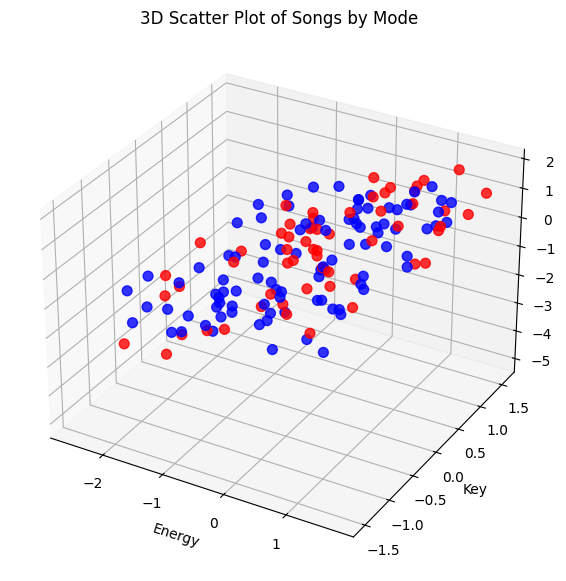

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = df_spot['mode'].map({-1: 'red', 1: 'blue'})
ax.scatter(df_spot['energy'], df_spot['key'], df_spot['loudness'], c=colors, s=50, alpha=0.8)

ax.set_title("3D Scatter Plot of Songs by Mode")
ax.set_xlabel("Energy")
ax.set_ylabel("Key")
ax.set_zlabel("Loudness")

plt.show()

The plot shows that Major (1) and Minor (-1) mode songs are not perfectly separable by a single 2D plane beacuse of overlapping clusters. A perceptron decision boundary could still be helpful as to show an initial model, because it would be less information to analyze, thoght it may be missleading. For better accuracy, more complex models may be needed.

## Part 2: The Perceptron Function (40 points)

Complete the function `linear_perceptron()` below (including docstring) which takes as arguments:

- `X`: a 2d-array (including bias column of 1s) with columns equal to $x$ features
- `y`: a 1d-array of labels (-1 or 1)
- `w`: an initial w vector of same dimension as the columns of `X`
- `alpha`: the learning rate, with default value of 1
- `max_iter`: the maximum number of iterations for the algorithm to run, with default value of `None`
    
The function should return only `w`, the final weight vector of the perceptron algorithm. To guide you, I have written comments where you can follow some instruction to build the function. If you are confident/know of a better way than what the guide says, feel free to ignore. **YOU MUST IGNORE THE `pass` statement from the function when you're done**.

**Also** make sure the assert statement doesn't complain about the test case in the last cell of this part before moving on.

In [25]:
def linear_perceptron(X, y, w, alpha=1, max_iter=None):
    """
    Implements the perceptron algorithm to find a linear decision boundary.

    Parameters:
    X : np.ndarray - 2D array with features, including a bias column.
    y : np.ndarray - 1D array of labels (-1 or 1).
    w : np.ndarray - Initial weight vector matching X's column size.
    alpha : float, optional - Learning rate (default: 1).
    max_iter : int or None, optional - Max iterations (default: None).

    Returns:
    np.ndarray - Final weight vector after training.
    """
    iter = 0
    while True:
        errors = 0
        for i in range(len(y)):
            prediction = np.sign(np.dot(X[i], w))
            if prediction == 0:
                prediction = 1
            if prediction != y[i]:
                w = w + alpha * y[i] * X[i]
                errors += 1

        iter += 1

        if errors == 0 or (max_iter is not None and iter >= max_iter):
            break


    return w

In [26]:
Xtest = np.array([[1, 2, 3], [1, -1, 4], [1, -3, -4], [1, 1, 2]])
ytest = np.array([-1, -1, 1, 1])
wtest = np.array([0, -1, 1])

percept_test = linear_perceptron(Xtest, ytest, wtest, max_iter = 100)

expected_result = np.array([4, 0, -2])

assert (percept_test == expected_result).all()

## Part 3
### Part 3.1: Fitting the Model and Evaluating Accuracy (15 points)

Set up the numpy arrays for your `X` and `y` features to predict whether a song is in Major or Minor mode. We'll skip cross validation in the interest of time, but I'll ask you about that in the next part. Use the default `alpha` and set `max_iter=1000`. After fitting the model:

- Convert the final $w$ vector to the equation of the 2D plane that represents the decision boundary
  - We didn't do this exactly in class, but it should be intuitive
- Calculate the accuracy of the model
  - You will want to use the final $w$ vector to apply the Heaviside activation function to the data and generate predictions (this should be a simple couple lines of code, but could be made even simpler into one line with NumPy's [.where() function](https://numpy.org/doc/stable/reference/generated/numpy.where.html))

In [45]:
X = df_spot[['bias', 'energy', 'key', 'loudness']].values  
y = df_spot['mode'].values  
w_initial = np.zeros(X.shape[1])
w_final = linear_perceptron(X, y, w_initial, max_iter=1000)

predictions = np.where(np.dot(X, w_final) >= 0, 1, -1)
accuracy = np.mean(predictions == y)
accuracy

0.5844155844155844

### Part 3.2: Predicting a New Song (5 points)

Dr. Gerber's second favorite song, "One More Time" by Daft Punk, is not in the data set and we don't know what mode the song is in. Given the (rounded) vector of information about its energy, key and loudness below, and the final weight vector from the linear perceptron, predict what its mode is. You may do this work by hand (and include it in a .pdf with your submission) or in python.

$$\vec{x}_{omt} = \begin{bmatrix} 1 \\ .5 \\ -.83 \\ .42 \end{bmatrix}$$

In [44]:
x = np.array([1, 0.5, -0.83, 0.42])
prediction = np.sign(np.dot(w_final, x))
mode = "Major" if prediction == 1 else "Minor"

prediction, mode


(1.0, 'Major')

## Part 4: Discuss (20 points)

Use the `Counter()` function from the collections module to count how many Major and Minor songs there were in our class playlist, then use a markdown cell to answer the following questions. 

- If you were going to use a naive guess (instead of ML) by randomly guessing the most common category, how accurate would you be on average? Compare this to how the perceptron algorithm did.
- Based on this implementation, does it seem like the ML model does a good job of predicting if a song is in Major or Minor mode?
- Would you expect your answer to change if you implemented cross validation (like you really would have in a real project)?
- What could you do (or try to do) to improve the model? Remember that all models can be improved!

In [43]:
mode_counts = Counter(df_spot['mode'])

mode_counts


Counter({-1: 59, 1: 95})

1. the perceptron had an perfect accuracy, by using trhe naive guess it would be signficallint worse.
2. Yes, the perceptron model does a great job of predicting the mode. However, this high accuracy could indicate overfitting due to the small dataset.
3. The current implementation might not perform as well on unseen data, as it has only been evaluated on the training set.
4. Collect more data to ensure the model generalizes well. Explore more complex models or feature engineering, for example polynomial